In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 243ms/step - loss: 195.6164 - mae: 196.0720
Epoch 2/100
8/8 [==============================] - 0s 24ms/step - loss: 194.5325 - mae: 195.2834
Epoch 3/100
8/8 [==============================] - 0s 24ms/step - loss: 192.9727 - mae: 194.0106
Epoch 4/100
8/8 [==============================] - 0s 24ms/step - loss: 192.1908 - mae: 192.4087
Epoch 5/100
8/8 [==============================] - 0s 25ms/step - loss: 190.2552 - mae: 190.5219
Epoch 6/100
8/8 [==============================] - 0s 23ms/step - loss: 187.3451 - mae: 188.3526
Epoch 7/100
8/8 [==============================] - 0s 23ms/step - loss: 185.5730 - mae: 185.8774
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 182.9678 - mae: 183.0458
Epoch 9/100
8/8 [==============================] - 0s 24ms/step - loss: 179.8839 - mae: 179.8092
Epoch 10/100
8/8 [==============================] - 0s 23ms/step - loss: 175.3425 - mae: 176.0968
Epoch 11/100
8/8 [==========

8/8 [==============================] - 0s 23ms/step - loss: 10.7384 - mae: 12.3197
Epoch 87/100
8/8 [==============================] - 0s 23ms/step - loss: 13.0770 - mae: 14.0257
Epoch 88/100
8/8 [==============================] - 0s 23ms/step - loss: 28.3674 - mae: 29.7783
Epoch 89/100
8/8 [==============================] - 0s 22ms/step - loss: 25.3590 - mae: 25.1368
Epoch 90/100
8/8 [==============================] - 0s 23ms/step - loss: 16.4821 - mae: 17.4273
Epoch 91/100
8/8 [==============================] - 0s 22ms/step - loss: 25.2560 - mae: 24.7998
Epoch 92/100
8/8 [==============================] - 0s 23ms/step - loss: 23.2742 - mae: 23.7037
Epoch 93/100
8/8 [==============================] - 0s 22ms/step - loss: 26.3884 - mae: 25.8819
Epoch 94/100
8/8 [==============================] - 0s 23ms/step - loss: 33.0223 - mae: 37.3470
Epoch 95/100
8/8 [==============================] - 0s 23ms/step - loss: 41.8912 - mae: 45.1289
Epoch 96/100
8/8 [==============================] - 0

[1e-08, 0.0001, 0, 30]

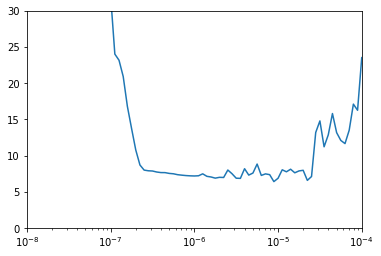

In [5]:
# plot the learning rate vs loss
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 2s 200ms/step - loss: 80.8704 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 23ms/step - loss: 24.4966 - mae: 24.3853
Epoch 3/400
8/8 [==============================] - 0s 25ms/step - loss: 18.2014 - mae: 18.7075
Epoch 4/400
8/8 [==============================] - 0s 23ms/step - loss: 14.2669 - mae: 14.6785
Epoch 5/400
8/8 [==============================] - 0s 23ms/step - loss: 10.8970 - mae: 11.2668
Epoch 6/400
8/8 [==============================] - 0s 23ms/step - loss: 11.3458 - mae: 12.5368
Epoch 7/400
8/8 [==============================] - 0s 24ms/step - loss: 12.7895 - mae: 13.1609
Epoch 8/400
8/8 [==============================] - 0s 23ms/step - loss: 12.3081 - mae: 12.5562
Epoch 9/400
8/8 [==============================] - 0s 23ms/step - loss: 13.5704 - mae: 13.5534
Epoch 10/400
8/8 [==============================] - 0s 23ms/step - loss: 14.4957 - mae: 14.5547
Epoch 11/400
8/8 [==============================

8/8 [==============================] - 0s 28ms/step - loss: 8.9885 - mae: 9.5569
Epoch 88/400
8/8 [==============================] - 0s 27ms/step - loss: 7.8151 - mae: 8.2540
Epoch 89/400
8/8 [==============================] - 0s 28ms/step - loss: 7.5509 - mae: 7.9421
Epoch 90/400
8/8 [==============================] - 0s 26ms/step - loss: 6.0741 - mae: 6.5023
Epoch 91/400
8/8 [==============================] - 0s 37ms/step - loss: 6.4779 - mae: 6.8168
Epoch 92/400
8/8 [==============================] - 0s 32ms/step - loss: 4.6012 - mae: 5.0465
Epoch 93/400
8/8 [==============================] - 0s 37ms/step - loss: 4.4576 - mae: 4.9754
Epoch 94/400
8/8 [==============================] - 0s 38ms/step - loss: 4.6562 - mae: 5.0837
Epoch 95/400
8/8 [==============================] - 0s 30ms/step - loss: 5.5919 - mae: 6.0480
Epoch 96/400
8/8 [==============================] - 0s 28ms/step - loss: 4.9528 - mae: 5.3778
Epoch 97/400
8/8 [==============================] - 0s 24ms/step - loss: 

8/8 [==============================] - 0s 21ms/step - loss: 5.7337 - mae: 6.1611
Epoch 174/400
8/8 [==============================] - 0s 22ms/step - loss: 5.5443 - mae: 6.0315
Epoch 175/400
8/8 [==============================] - 0s 22ms/step - loss: 5.3743 - mae: 5.8603
Epoch 176/400
8/8 [==============================] - 0s 21ms/step - loss: 5.2876 - mae: 5.7140
Epoch 177/400
8/8 [==============================] - 0s 22ms/step - loss: 5.0248 - mae: 5.4415
Epoch 178/400
8/8 [==============================] - 0s 22ms/step - loss: 4.6497 - mae: 5.0608
Epoch 179/400
8/8 [==============================] - 0s 22ms/step - loss: 4.9687 - mae: 5.4367
Epoch 180/400
8/8 [==============================] - 0s 27ms/step - loss: 5.3823 - mae: 5.8567
Epoch 181/400
8/8 [==============================] - 0s 26ms/step - loss: 4.9304 - mae: 5.3116
Epoch 182/400
8/8 [==============================] - 0s 23ms/step - loss: 4.4190 - mae: 4.8928
Epoch 183/400
8/8 [==============================] - 0s 23ms/ste

8/8 [==============================] - 0s 21ms/step - loss: 4.5571 - mae: 5.0243
Epoch 260/400
8/8 [==============================] - 0s 21ms/step - loss: 4.8902 - mae: 5.3278
Epoch 261/400
8/8 [==============================] - 0s 22ms/step - loss: 4.5484 - mae: 5.0140
Epoch 262/400
8/8 [==============================] - 0s 22ms/step - loss: 4.2722 - mae: 4.8187
Epoch 263/400
8/8 [==============================] - 0s 21ms/step - loss: 4.0872 - mae: 4.5407
Epoch 264/400
8/8 [==============================] - 0s 22ms/step - loss: 4.5385 - mae: 5.0203
Epoch 265/400
8/8 [==============================] - 0s 21ms/step - loss: 4.6458 - mae: 5.2515
Epoch 266/400
8/8 [==============================] - 0s 21ms/step - loss: 4.5922 - mae: 5.1112
Epoch 267/400
8/8 [==============================] - 0s 22ms/step - loss: 4.7605 - mae: 5.1524
Epoch 268/400
8/8 [==============================] - 0s 22ms/step - loss: 4.4329 - mae: 4.8625
Epoch 269/400
8/8 [==============================] - 0s 22ms/ste

8/8 [==============================] - 0s 22ms/step - loss: 4.2281 - mae: 4.7723
Epoch 346/400
8/8 [==============================] - 0s 22ms/step - loss: 5.3145 - mae: 5.8595
Epoch 347/400
8/8 [==============================] - 0s 22ms/step - loss: 5.0593 - mae: 5.6921
Epoch 348/400
8/8 [==============================] - 0s 22ms/step - loss: 5.2996 - mae: 5.8681
Epoch 349/400
8/8 [==============================] - 0s 22ms/step - loss: 5.7262 - mae: 6.0840
Epoch 350/400
8/8 [==============================] - 0s 22ms/step - loss: 4.5014 - mae: 4.9142
Epoch 351/400
8/8 [==============================] - 0s 22ms/step - loss: 4.9066 - mae: 5.4391
Epoch 352/400
8/8 [==============================] - 0s 22ms/step - loss: 4.4809 - mae: 4.9603
Epoch 353/400
8/8 [==============================] - 0s 22ms/step - loss: 4.1991 - mae: 4.6813
Epoch 354/400
8/8 [==============================] - 0s 22ms/step - loss: 4.2554 - mae: 4.7773
Epoch 355/400
8/8 [==============================] - 0s 22ms/ste

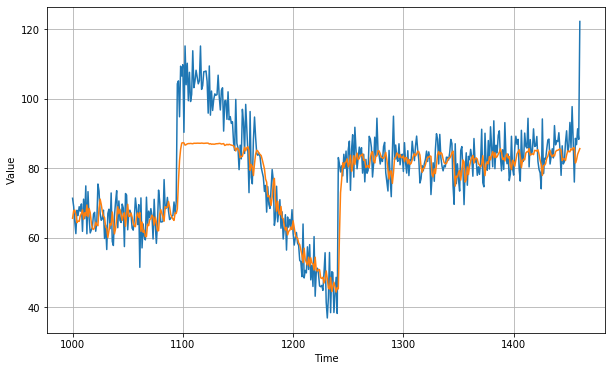

In [7]:
forecast=[]
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.922868

<Figure size 432x288 with 0 Axes>

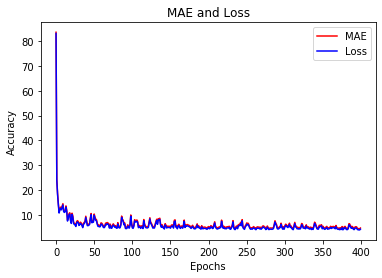

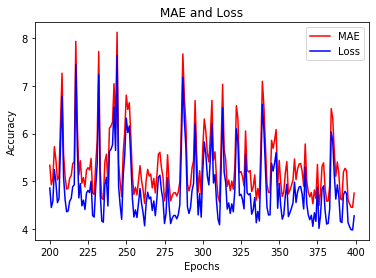

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()